# 利用EC数据绘制中长期数据

20.0 2.0
CPU times: user 13.1 s, sys: 3.58 s, total: 16.6 s
Wall time: 38.3 s


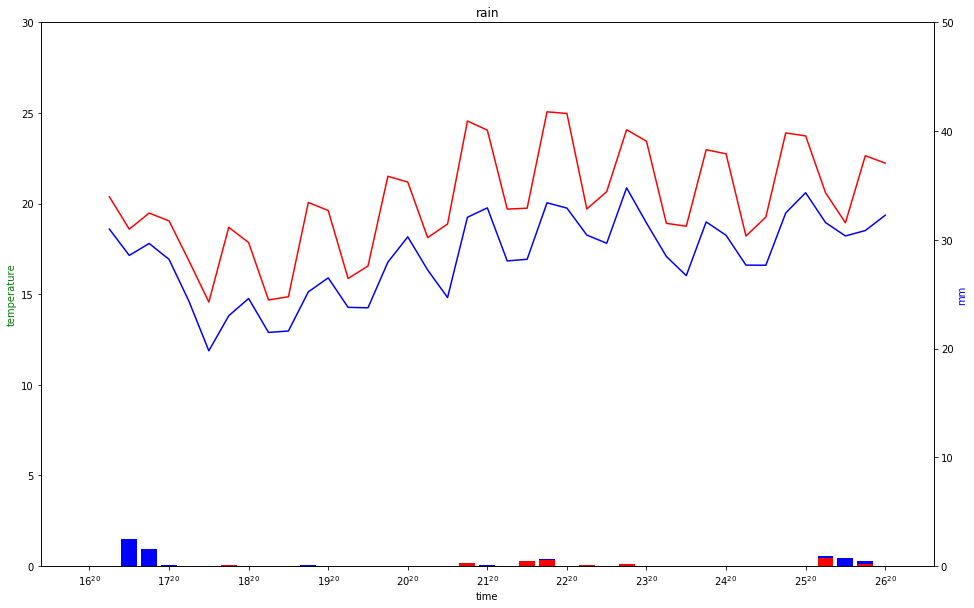

In [7]:
%%time
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.interpolate import interp1d
import xesmf as xe
import redis
import pandas as pd
import datetime
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import os
import random
from io import BytesIO
import base64

class ec_data_point:
    def __init__(self,select_time,select_type,select_county):
        self.timelist = [0,2,4,6,8,10,12,14,16,18,20,22,24,25,
                         26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,
                        41,42,43,44,45,46,47,48,49,50,51,52]
        self.county = select_county
        self.file_path = "/workspace/Data/My_Git/" + select_time + "/" 
        self.data  = self.read_data()
        self.rain = None
    def county_location(self,select_county):
        '''用于返回乡镇对应的经纬度'''
        county = {
            '仙居':[28.6,121.4]
        }
        return county[select_county]
    def read_data(self):
        '''读取基础数据'''
        files = os.listdir(self.file_path)
        f=xr.open_dataset(self.file_path + files[0],decode_times=False)
        for fileitem in self.timelist[1:]:
            f0=xr.open_dataset(self.file_path +files[fileitem],decode_times=False)
            f=xr.concat([f,f0],dim="time")
        # 读取降水和气温的基本数据
        lsp = f.tp.sel(lonS=slice(118,123),latS=slice(32,26))
        tmax2 = f.tmax2.sel(lonS=slice(118,123),latS=slice(32,26))
        tmin2 = f.tmin2.sel(lonS=slice(118,123),latS=slice(32,26))
        cp = f.cp.sel(lonS=slice(118,123),latS=slice(32,26))
        # 读取单点的分析图
        u = f.u.sel(lonP=slice(118,123),latP=slice(32,26))
        v = f.v.sel(lonP=slice(118,123),latP=slice(32,26))
        r = f.r.sel(lonP=slice(118,123),latP=slice(32,26))
        data = {
            'lsp':lsp,
            'tmax':tmax2,
            'tmin':tmin2,
            'cp':cp,
            'u':u,
            'v':v,
            'r':r
        }
        return data
    def accum_data(self,list_data):
        '''处理累计降水'''
        out_list = []
        for i in range(len(list_data)):
            if i==0:
                out_list.append(0)
            else:
                out_list.append(list_data[i]-list_data[i-1])
        return out_list  
    def decode_data(self,select_county,select_type):
        '''解析所需数据的列表'''
        lat = self.county_location(select_county)[0]
        lon = self.county_location(select_county)[1]
        if select_type=='rain':
            cp  = self.data['cp'].sel(lonS=lon, latS=lat,method='nearest').to_pandas().tolist()
            lsp  = self.data['lsp'].sel(lonS=lon, latS=lat,method='nearest').to_pandas().tolist()
            tmax_data  = self.data['tmax'].sel(lonS=lon, latS=lat,method='nearest').to_pandas().tolist()
            tmin_data  = self.data['tmin'].sel(lonS=lon, latS=lat,method='nearest').to_pandas().tolist()
            cp_data = self.accum_data(cp)
            pre_data = self.accum_data(lsp)
            return tmax_data,tmin_data,cp_data,pre_data
        else:
            u  = self.data['u'].sel(lonP=lon, latP=lat,method='nearest').transpose('lev', 'time').to_pandas().values
            v  = self.data['v'].sel(lonP=lon, latP=lat,method='nearest').transpose('lev', 'time').to_pandas().values
            r  = self.data['r'].sel(lonP=lon, latP=lat,method='nearest').transpose('lev', 'time').to_pandas().values
            print(self.data['r'].sel(lonP=lon, latP=lat,method='nearest').transpose('lev', 'time'))
            return u,v,r
    def decode_time(self,select_time):
        #2022101612
        year = int(select_time[0:4])
        month = int(select_time[4:6])
        day = int(select_time[6:8])
        hour = select_time[8:]
        start = datetime.date(year, month, day)
        end = (start + datetime.timedelta(days = 10)).strftime("%Y-%m-%d")
        if hour=='12':
            start_day = start.strftime("%Y-%m-%d") +" " + "20:00"
            end_day = end +" " + "20:00"
        else:
            start_day = start.strftime("%Y-%m-%d") +" " + "08:00"
            end_day = end +" " + "08:00"
        time_data = pd.date_range(start=start_day,end=end_day,freq='24H')
        ticks = [0,4,8,12,16,20,24,28,32,36,40]
        label = []
        for i in time_data:
            label.append(i.strftime("%Y-%m-%d")[8:10] + "$^{20}$")
        return ticks,label
    def plot_rain(self,select_county):
        '''用于绘制指定经纬度的降水、高温、低温数据'''
        # 模拟的数据
        fig1, ax1 = plt.subplots(figsize=[16,10]) 
        tmax_data,tmin_data,cp_data,pre_data  = self.decode_data(select_county,select_type)
        tmean = (np.nanmean(tmax_data) // 2 ) * 2
        pmax = (np.nanmax(pre_data) // 2 ) * 2
        print(tmean,pmax)
        time_line =  [f"{i}" for i in range(0, 41)]  
        # 画图，plt.bar()可以画柱状图    
        ax2 = ax1.twinx() 
        # 画图，plt.bar()可以画柱状图    
        ax2.bar(time_line, pre_data,color = "blue")
        ax2.bar(time_line, cp_data,color = "red")
        ax1.plot(time_line, tmax_data,color = "red")
        ax1.plot(time_line, tmin_data,color = "blue")
        # 设置图片名称
        plt.title("rain")
        # 设置x轴标签名
        ax1.set_ylim(tmean-20,tmean+10)
        #ax2.set_ylim(0,pmax*2.3)
        ax2.set_ylim(0,50)
        ticks,label = self.decode_time(select_time)
        plt.xticks(ticks,label)
        ax1.set_xlabel('time')    #设置x轴标题
        ax1.set_ylabel('temperature',color = 'g')   #设置Y1轴标题
        ax2.set_ylabel('mm',color = 'b')   #设置Y2轴标题
        #plt.show()
        imd = self.decode_base64(plt)
    def plot_wind(self,select_county):
        '''用于绘制指定经纬度的风场、相对湿度、等高线数据'''
        lat = self.county_location(select_county)[0]
        lon = self.county_location(select_county)[1]
        u,v,r  = self.decode_data(select_county,select_type)
        # 模拟的数据     
        x = np.linspace(0,41 , 41) 
        y = np.linspace(0,15, 15)#[1000,925,850,700,500,200,100]#np.linspace(0,15, 7) 
        X, Y = np.meshgrid(x, y) 
        U, V = u,v
        Z2 = r
        fig1, axs1 = plt.subplots(figsize=[16,10]) 
        #axs1.invert_yaxis() 
        #axs1.contour(X,Y,Z,8,alpha=0.75,cmap='hot')
        colorslist = ['#FFFFFF','#B4F0FA','#96D2FA','#50A5F5','#1E78DC']# 相对湿度
        cmaps = LinearSegmentedColormap.from_list('mylist',colorslist,N=5)
        levels = [0,80,85,90,95,100]
        axs1.contourf(X,Y,Z2,cmap=cmaps,add_labels=True)
        axs1.barbs(X, Y, U, V) 
        ticks,label = self.decode_time(select_time)
        plt.xticks(ticks,label)
        #plt.show()
        imd = self.decode_base64(plt)
    def decode_base64(self,plt):
        '''解析base64类型的数据'''
        buffer = BytesIO()
        plt.savefig(buffer,bbox_inches='tight')  
        plot_img = buffer.getvalue()
        imb = base64.b64encode(plot_img) 
        ims = imb.decode()
        imd = "data:image/png;base64,"+ims
        return imd
        

        
        
        




#select_time,select_type,select_county = '2022041700','rain','仙居'
#select_time,select_type,select_county = '2022041700','wind','仙居'
select_time,select_type,select_county = '2022101612','rain','仙居'
ec_worker = ec_data_point(select_time,select_type,select_county) 
#ec_worker.plot_wind(select_county)
ec_worker.plot_rain(select_county)
# ec_worker.decode_data(select_county)

# ec_worker.decode_time(select_time)

In [53]:
# 时间测试
def decode_time(select_time):
    #2022101612
    year = int(select_time[0:4])
    month = int(select_time[4:6])
    day = int(select_time[6:8])
    hour = select_time[8:]
    start = datetime.date(year, month, day)
    end = (start + datetime.timedelta(days = 10)).strftime("%Y-%m-%d")
    if hour=='12':
        start_day = start.strftime("%Y-%m-%d") +" " + "20:00"
        end_day = end +" " + "20:00"
    else:
        start_day = start.strftime("%Y-%m-%d") +" " + "08:00"
        end_day = end +" " + "08:00"
    time_data = pd.date_range(start=start_day,end=end_day,freq='24H')
    #["Q$^{2}$" ]
    ticks = [0,4,8,12,16,20,24,28,32,36,40]
    label = []
    for i in time_data:
        label.append(i.strftime("%Y-%m-%d")[8:10] + "$^{20}$") 
        
    #label = [f"{i.strftime("%Y-%m-%d")[0:5]}"+"$^{20}$" for i in time_data]  
    print(label,time_data)
# time_data = pd.date_range(start='2022-04-17 20:00',end='2022-04-27',freq='24H')
# time_data[0].strftime("%Y-%m-%d")[0:5]
decode_time('2022101612')

['16$^{20}$', '17$^{20}$', '18$^{20}$', '19$^{20}$', '20$^{20}$', '21$^{20}$', '22$^{20}$', '23$^{20}$', '24$^{20}$', '25$^{20}$', '26$^{20}$'] DatetimeIndex(['2022-10-16 20:00:00', '2022-10-17 20:00:00',
               '2022-10-18 20:00:00', '2022-10-19 20:00:00',
               '2022-10-20 20:00:00', '2022-10-21 20:00:00',
               '2022-10-22 20:00:00', '2022-10-23 20:00:00',
               '2022-10-24 20:00:00', '2022-10-25 20:00:00',
               '2022-10-26 20:00:00'],
              dtype='datetime64[ns]', freq='24H')


# 第一张图的测试

20.0 48


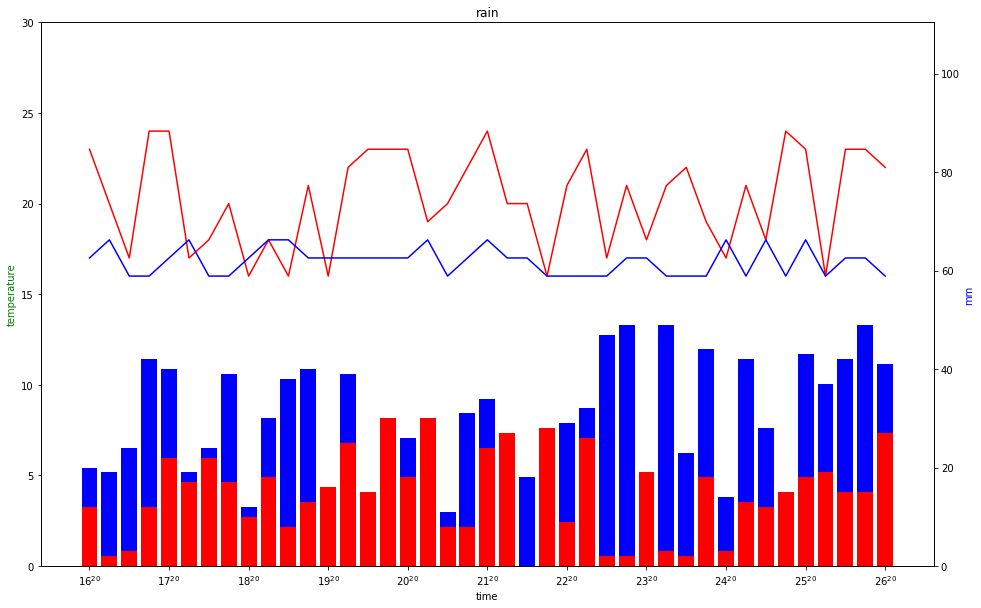

In [54]:
import matplotlib.pyplot as plt
import numpy as np
# 模拟的数据
fig1, ax1 = plt.subplots(figsize=[16,10]) 
time_line =  [f"{i}" for i in range(0, 41)]
pre_data = [random.randint(0, 50) for i in range(41)]
cp_data =  [random.randint(0, 30) for i in range(41)]
tmax_data =  [random.randint(16, 24) for i in range(41)]
tmin_data =  [random.randint(16, 18) for i in range(41)]

tmean = (np.mean(tmax_data) // 2 ) * 2

pmax = (np.max(pre_data) // 2 ) * 2
print(tmean,pmax)
ax2 = ax1.twinx() 
# 画图，plt.bar()可以画柱状图    
ax2.bar(time_line, pre_data,color = "blue")
ax2.bar(time_line, cp_data,color = "red")
ax1.plot(time_line, tmax_data,color = "red")
ax1.plot(time_line, tmin_data,color = "blue")
# 设置图片名称
plt.title("rain")
# 设置x轴标签名
ax1.set_xlabel('time')    #设置x轴标题
plt.xticks([0,4,8,12,16,20,24,28,32,36,40],['16$^{20}$', '17$^{20}$', '18$^{20}$', '19$^{20}$', '20$^{20}$', '21$^{20}$', '22$^{20}$', '23$^{20}$', '24$^{20}$', '25$^{20}$', '26$^{20}$'])
# ax1.set_xticks([0,4,8])


ax1.set_ylabel('temperature',color = 'g')   #设置Y1轴标题
ax1.set_ylim(tmean-20,tmean+10)
ax2.set_ylabel('mm',color = 'b')   #设置Y2轴标题
ax2.set_ylim(0,pmax*2.3)
# 显示
plt.show()

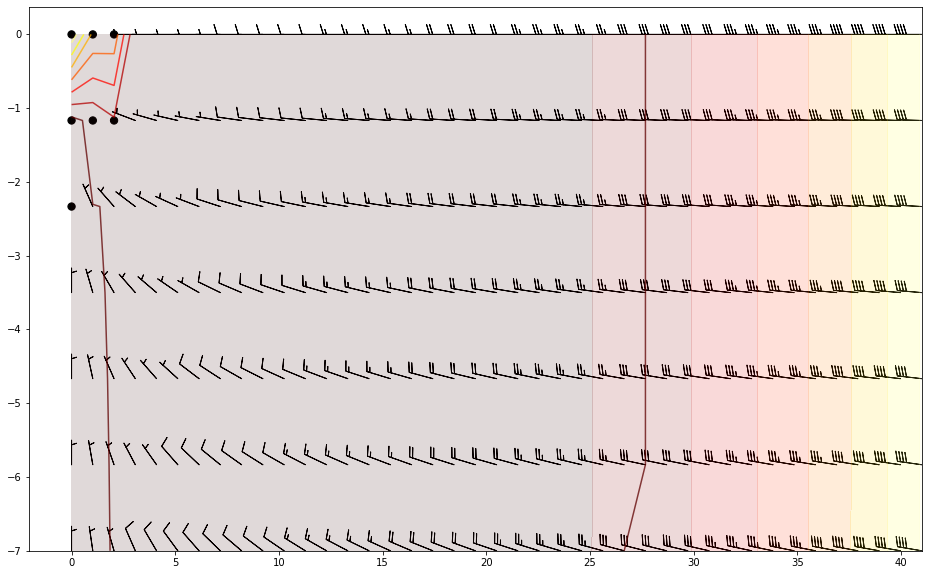

In [14]:
x = np.linspace(0, 41, 41) 
y = np.linspace(0, -7, 7) 
X, Y = np.meshgrid(x, y) 

U, V = X, Y
Z = (1-X/2+X**5+Y**1)*np.exp(-X**2-Y**2)
Z2 = X**4 + Y**4

# print(U)
fig1, axs1 = plt.subplots(figsize=[16,10]) 
axs1.barbs(X, Y, U, V, fill_empty = True) 
axs1.contour(X,Y,Z,8,alpha=0.75,cmap='hot')
axs1.contourf(X,Y,Z2,8,alpha=0.15,cmap='hot')
plt.show()

In [6]:
import pandas as pd

data = [['Google',10],['Runoob',12],['Wiki',13]]

df = pd.DataFrame(data,columns=['Site','Age'],dtype=float)

print(df.values)

[['Google' 10.0]
 ['Runoob' 12.0]
 ['Wiki' 13.0]]
